In [0]:
import keras
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM 
from statsmodels.tools.eval_measures import rmse

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials 
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
df = drive.CreateFile({'id':'1rAuL77nhjhZnWhGsDqujZK7mOzmYVE63'})
df.GetContentFile('Alcohol_Sales.csv')
df = pd.read_csv("Alcohol_Sales.csv", index_col = "DATE", parse_dates = True)

In [129]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


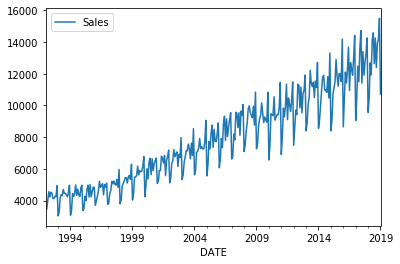

In [130]:
df.columns = ["Sales"]
df.plot()

In [0]:
results = seasonal_decompose(df["Sales"])

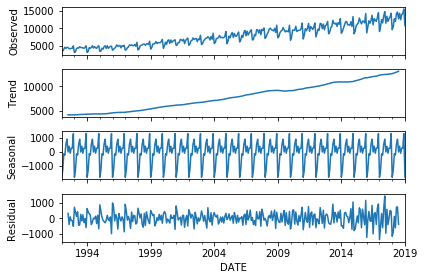

In [132]:
results.plot();

In [0]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series, title = ""):
  print(f'Augmented Dickey-fuller test : {title}')
  result = adfuller(series.dropna(),autolag='AIC')

  labels = ['ADF test statistic','p-value','# lags used','# Observations']
  out = pd.Series(result[0:4], index = labels)

  for key, val in result[4].items():
    out[f'critical value ({key})'] = val

  print(out.to_string())
  if result[1] <=0.05:
    print("Strong evidence against null hypothesis")
    print("Reject the null hypothesis")
    print("Data has no unit root and is stationary")
  else:
    print("Weak evidence against the null hypothesis")
    print("Fail to reject the null hypothesis")
    print("Data has a unit root and is non-stationary")


In [135]:
adf_test(df["Sales"])

Augmented Dickey-fuller test : 
ADF test statistic        2.037405
p-value                   0.998720
# lags used              14.000000
# Observations          310.000000
critical value (1%)      -3.451622
critical value (5%)      -2.870909
critical value (10%)     -2.571762
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [136]:
len(df)

325

In [0]:
train = df.iloc[:313]
test = df.iloc[313:]

In [0]:
scalar = MinMaxScaler()

In [139]:
scalar.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
scaled_train = scalar.transform(train)

In [0]:
scaled_train = scalar.transform(train)
scaled_test = scalar.transform(test)

In [0]:
n_input = 12
n_features = 1

train_generator = TimeseriesGenerator(scaled_train,scaled_train, length=n_input, batch_size=2)

In [0]:
model = Sequential()
model.add(LSTM(150, activation = "relu", input_shape = (n_input,n_features)))
model.add(Dense(1))
model.compile(optimizer = "adam",loss="mse")

In [148]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [149]:
model.fit_generator(train_generator, epochs=25)

Epoch 1/25
151/151 [==============================] - 3s 22ms/step - loss: 0.0290
Epoch 2/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0098
Epoch 3/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0098
Epoch 4/25
151/151 [==============================] - 2s 15ms/step - loss: 0.0091
Epoch 5/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0083
Epoch 6/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0086
Epoch 7/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0085
Epoch 8/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0084
Epoch 9/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0080
Epoch 10/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0074
Epoch 11/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0057
Epoch 12/25
151/151 [==============================] - 2s 16ms/step - loss: 0.0051
Epoch 13/25
1

In [150]:
model.history.history.keys()

dict_keys(['loss'])

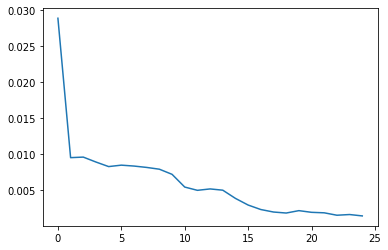

In [151]:
myloss=model.history.history["loss"]
plt.plot(range(len(model.history.history["loss"])),model.history.history["loss"])

In [152]:
first_eval_batch = scaled_train[-12:]
first_eval_batch

array([[0.63432772],
       [0.80776135],
       [0.72313873],
       [0.89870929],
       [1.        ],
       [0.71672793],
       [0.88648602],
       [0.75869732],
       [0.82742115],
       [0.87443371],
       [0.96025301],
       [0.5584238 ]])

In [0]:
first_eval_batch = first_eval_batch.reshape((1,n_input,n_features))

In [154]:
model.predict(first_eval_batch)

array([[0.74606407]], dtype=float32)

Forecasting Using RNN

In [0]:
test_predictions = []
first_eval_batch=scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input,n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [156]:
test_predictions

[array([0.74606407], dtype=float32),
 array([0.9040689], dtype=float32),
 array([0.8626507], dtype=float32),
 array([1.0376707], dtype=float32),
 array([1.1307392], dtype=float32),
 array([0.8692077], dtype=float32),
 array([1.0102794], dtype=float32),
 array([0.8784999], dtype=float32),
 array([0.9479362], dtype=float32),
 array([1.0013396], dtype=float32),
 array([1.0773318], dtype=float32),
 array([0.69602686], dtype=float32)]

In [0]:
true_predictions = scalar.inverse_transform(test_predictions)

In [158]:
test["Predictions"] = true_predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


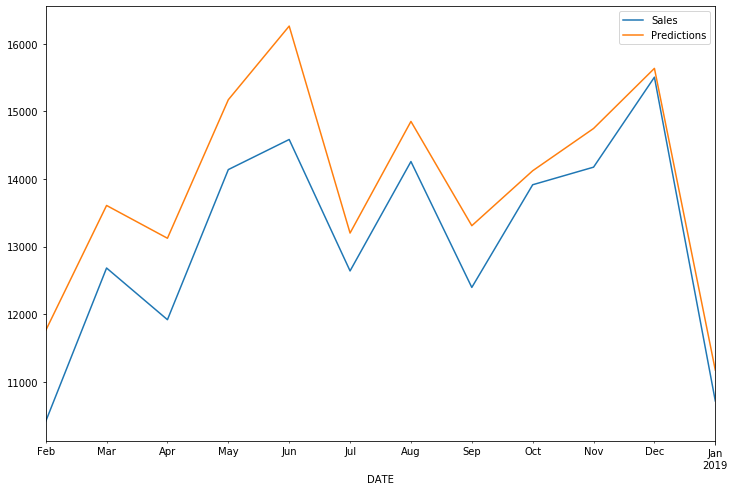

In [159]:
test.plot(figsize = (12,8))

In [160]:
test.columns

Index(['Sales', 'Predictions'], dtype='object')

In [161]:
rmse(test["Sales"],test["Predictions"])

916.5967271857353

In [162]:
test["Sales"].mean()

13111.75